<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/b-vanilla-neural-network-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Backpropagation algorithm from scratch



In this section, we will learn how to implement the backpropagation algorithm from scratch using Python. 

**What is Backpropagation?**
Back-propagation is the essence of neural net training. It is the method of fine-tuning the weights of a neural net based on the error rate obtained in the previous epoch (i.e., iteration). Proper tuning of the weights allows you to reduce error rates and to make the model reliable by increasing its generalization.

Backpropagation is a short form for "backward propagation of errors." It is a standard method of training artificial neural networks. This method helps to calculate the gradient of a loss function with respects to all the weights in the network.

The backpropagation algorithm consists of two phases:
- 1. The forward pass where we pass our inputs through the network to obtain our output classifications.

-  2. The backward pass (i.e., weight update phase) where we compute the gradient of the loss function and use this information to iteratively apply the chain rule to update the weights in our network.

<img src="https://www.guru99.com/images/1/030819_0937_BackPropaga1.png">



In [97]:
from __future__ import print_function
import numpy as np
from IPython.display import clear_output
np.random.seed(42)

# Concepts

Before we dive into our neural network implementation, lets look at some important concepts.

## The dot product

The dot product of two vectors tells you how similar they are in terms of direction and is scaled by the magnitude of the two vectors.



In [98]:
input_vector = [1.72, 1.23]
weights_1 = [1.26, 0]
weights_2 = [2.17, 0.32]

# Computing the dot product of input_vector and weights_1
first_indexes_mult = input_vector[0] * weights_1[0]
second_indexes_mult = input_vector[1] * weights_1[1]
dot_product_1 = first_indexes_mult + second_indexes_mult

print(f"The dot product 1 is: {dot_product_1}")

#use np instead
dot_product_2 = np.dot(input_vector, weights_2)
print(f"The dot product 2 is: {dot_product_2}")
print(f"The dot product 2 is closer: {dot_product_2} > {dot_product_1}")

The dot product 1 is: 2.1672
The dot product 2 is: 4.1259999999999994
The dot product 2 is closer: 4.1259999999999994 > 2.1672


## Matrix multiplication

The fundamental operations of any typical neural network can be reduced to a bunch of addition and multiplication operations. Neural networks can be expressed in terms of matrices. Matrix multiplication is one of the most important mathematical operations when it comes to deep neural networks.

Below a very simple "neural net" for helping to understand matrix multiplication

In [99]:
#weights for 2 neurons
weights_for_layer1 = np.array([
	[1.5, -0.5],
	[-1, 1]
])

#weights for 1 neurons
weights_for_layer2 = np.array([
	[-1],
	[1],
])

def neural_net(inputs, layer_weights):
	outputs = inputs
	#The output of a layer become the input for the subsequent layer
	for layer_weight in layer_weights:
		inputs = outputs
		outputs = np.matmul(inputs, layer_weight)
	return outputs


inputs = [
	[0, 0],
	[1, 0],
	[0, 1],
	[1, 1]
]

for i in inputs:
	print(
		i,
		" -> ",
		neural_net(
			inputs=np.array([i]),
			layer_weights=[weights_for_layer1, weights_for_layer2]
		)
	)

[0, 0]  ->  [[0.]]
[1, 0]  ->  [[-2.]]
[0, 1]  ->  [[2.]]
[1, 1]  ->  [[0.]]


# Implementing a Backpropagation algorithm

A neural network is compound by multiple layers.

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().


In [100]:
class Layer:
	"""
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """

	def __init__(self):
		"""Here we can initialize layer parameters (if any) and auxiliary stuff."""
		# A dummy layer does nothing
		pass

	def forward(self, input):
		"""
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
		# A dummy layer just returns whatever it gets as input.
		return input

	def backward(self, input, grad_output):
		"""
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. linear layer), we also need to update them here using d loss / d layer
        """
		return input

### Linear layer

A linear layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [101]:
class Linear(Layer):
	def __init__(self, input_size, output_size, learning_rate=0.1):
		"""
        A linear layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
		self.learning_rate = learning_rate
		self.weights = np.random.normal(loc=0.0,
										scale=np.sqrt(2 / (input_size + output_size)),
										size=(input_size, output_size))
		self.biases = np.zeros(output_size)

	def forward(self, img):
		"""
        Perform forward activation: f(x) = <W*x> + b
        
        input shape: [batch, input_size]
        output shape: [batch, output_size]
        """
		input = img.reshape([img.shape[0], -1])
		return np.dot(input, self.weights) + self.biases

	def backward(self, input, grad_output):
		# .T transposed weights
		grad_input = np.dot(grad_output, self.weights.T)

		# compute gradient with respect to weights and biases
		grad_weights = np.dot(input.T, grad_output)
		grad_biases = grad_output.mean(axis=0) * input.shape[0]

		assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

		# Here we perform a stochastic gradient descent step. Updating weights and biases to all layers in the network
		self.weights = self.weights - self.learning_rate * grad_weights
		self.biases = self.biases - self.learning_rate * grad_biases

		return grad_input

### The loss function

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1


In [102]:
def crossentropy_loss(predictions, labels):
	"""Calculate the softmax cross entropy loss for the predictions"""
	predictions_for_answers = predictions[np.arange(len(predictions)), labels]
	xentropy = - predictions_for_answers + np.log(np.sum(np.exp(predictions), axis=-1))
	return xentropy


## Why derivative/gradient is used ?

When updating the curve, to know in which direction and how much to change or update the curve depending upon the slope.

The error is given by the y-axis. If you’re in point A and want to reduce the error toward 0, then you need to bring the x value down. On the other hand, if you’re in point B and want to reduce the error, then you need to bring the x value up. To know which direction you should go to reduce the error, you’ll use the derivative. 

<img src="https://files.realpython.com/media/quatratic_function.002729dea332.png" width="500px">

The gradient is a vector; it points in the direction and derivative is a rate of change of , which can be thought of the slope of the function at a point .


In [103]:
def crossentropy_loss_grad_derivative(predictions, labels):
	"""Calculate the direction rate of the slope"""
	ones_for_answers = np.zeros_like(predictions)
	ones_for_answers[np.arange(len(predictions)), labels] = 1

	softmax = np.exp(predictions) / np.exp(predictions).sum(axis=-1, keepdims=True)

	return (- ones_for_answers + softmax) / predictions.shape[0]

## Learning rate

Is the step size at each iteration while moving toward a minimum of a loss function. Learning rate can not be too small or too big. 


<img src="https://srdas.github.io/DLBook/DL_images/TNN2.png">


## Activation function (Relu)
In a neural network, the purpose of an activation function is to add non-linearity to the neural network.

They allow backpropagation because now the derivative function would be related to the input, and it’s possible to go back and understand which weights in the input neurons can provide a better prediction.

They allow the stacking of multiple layers of neurons as the output would now be a non-linear combination of input passed through multiple layers. Any output can be represented as a functional computation in a neural network.

The rectified linear activation function is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.

```
if input > 0:
	return input
else:
	return 0
```

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="50%">


In [104]:
class ReLU(Layer):
	def __init__(self):
		"""ReLU layer simply applies elementwise rectified linear unit to all inputs"""
		pass

	def forward(self, input):
		"""Apply elementwise ReLU to [batch, input_units] matrix"""
		relu_forward = np.maximum(0, input)
		return relu_forward

	def backward(self, input, grad_output):
		"""Compute gradient of loss with respect to ReLU input"""
		relu_grad = input > 0
		return grad_output * relu_grad

# Train neural network

## Loading the dataset
Now let's combine what we've just built into a working neural network. As I have told earlier, we are going to use MNIST data of handwritten digit for our example.


This subset of the MNIST dataset is built-into the scikit-learn library and includes 1,797 example digits, each of which are 8 × 8 grayscale images (the original images are 28 × 28. When flattened, these images are represented by an 8 × 8 = 64-dim vector.

<img src="https://nvsyashwanth.github.io/machinelearningmaster/assets/images/digitsMNIST/samples.png"/>

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
import matplotlib.pyplot as plt

def load_dataset(flatten=False):
	# load the MNIST dataset and apply min/max scaling to scale the
	# pixel intensity values to the range [0, 1] (each image is
	# represented by an 8 x 8 = 64-dim feature vector)
	print("[INFO] loading MNIST (sample) dataset...")
	digits = datasets.load_digits()
	data = digits.data.astype("float")
	data = (data - data.min()) / (data.max() - data.min())  # normalization
	print("[INFO] samples: {}, dim: {}".format(data.shape[0], data.shape[1]))
	#X = data, Y = label
	X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.25)

	# we reserve the last 300 training examples for validation
	X_train, X_val = X_train[:-300], X_train[-300:]
	y_train, y_val = y_train[:-300], y_train[-300:]

	return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

[INFO] loading MNIST (sample) dataset...
[INFO] samples: 1797, dim: 64


# Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [106]:
from tqdm import trange


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
	assert len(inputs) == len(targets)
	if shuffle:
		indices = np.random.permutation(len(inputs))

	for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
		if shuffle:
			excerpt = indices[start_idx:start_idx + batchsize]
		else:
			excerpt = slice(start_idx, start_idx + batchsize)
		yield inputs[excerpt], targets[excerpt]

## Creating our network model

In [107]:
num_classes=10 # numbers from 0-9
input_size = 64
class NeuralNetwork:
	def __init__(self, learning_rate=0.1):
		# [input_size, 32, 16, 10]       
		# We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial. 
		self.network = []
		self.network.append(Linear(input_size, 100, learning_rate))
		self.network.append(ReLU())
		self.network.append(Linear(100, 200, learning_rate))
		self.network.append(ReLU())
		self.network.append(Linear(200, num_classes, learning_rate))

	def forward(self, img):
		"""
		Compute activations of all network layers by applying them sequentially.
		Return a list of activations for each layer. 
		"""
		predictions = []
		input = img

		# Looping through each layer
		for l in self.network:
			predictions.append(l.forward(input))
			input = predictions[-1] # Updating input to last layer output

		assert len(predictions) == len(self.network)
		return predictions

	def predict(self, img):
		"""
		Compute network predictions. Returning indices of largest probability
		"""
		prediction = self.forward(img)[-1]
		return prediction.argmax(axis=-1)

	def train(self, epoch, img_train, label_train, img_val, label_val):
		"""
		Train our network on a given batch of X and y.
		We first need to run forward to get all layer activations.
		Then we can run layer.backward going from last to first layer.
		After we have called backward for all layers, all Linear layers have already made one gradient step.
		"""
		train_logs = []
		val_logs = []
		for epoch in range(epoch):
			for x_batch, y_batch in iterate_minibatches(img_train, label_train, batchsize=32, shuffle=True):
				loss, loss_grad, layer_inputs = self.training_batch(x_batch, y_batch)
				self.backward(layer_inputs, loss_grad)

			train_log, val_log = self.validation_epoch_end(img_train, label_train, img_val, label_val)
			train_logs.append(loss)
			val_logs.append(val_log)

		return train_logs, val_logs

	def training_batch(self, img, label):
		# Get the layer activations
		layer_predictions = self.forward(img)
		layer_inputs = [img] + layer_predictions  # layer_input[i] is an input for network[i]
		last_prediction = layer_predictions[-1]

		# Compute the loss and the initial gradient
		loss = crossentropy_loss(last_prediction, label)
		loss_grad = crossentropy_loss_grad_derivative(last_prediction, label)

		return np.mean(loss), loss_grad, layer_inputs

	def validation_epoch_end(self, img_train, label_train, img_val, label_val):
		train_log = np.mean(self.predict(img_train) == label_train)
		val_log = np.mean(self.predict(img_val) == label_val)
		return val_log, train_log

	def backward(self, layer_inputs, loss_grad):
		# Propagate gradients through the network
		# Reverse loop as this is backprop
		for layer_index in range(len(self.network))[::-1]:
			layer = self.network[layer_index]
			layer_input = layer_inputs[layer_index]
			loss_grad = layer.backward(layer_input, loss_grad)  # grad w.r.t. input, also weight updates



Losses: 0.03483389020421904
Val accuracy: 0.9952244508118434


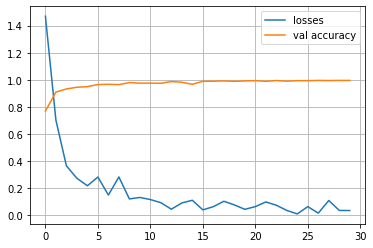

In [108]:
epoch = 30
model = NeuralNetwork(learning_rate=0.1)
train_log, val_log = model.train(epoch, X_train, y_train, X_val, y_val)
clear_output()
print("Losses:", train_log[-1])
print("Val accuracy:", val_log[-1])
plt.plot(train_log, label='losses')
plt.plot(val_log, label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


As we can see we have successfully trained a MLP which was purely written in numpy with high validation accuracy!

## Classification report.

Look at the precision column and you will see the percentage of right prediction to each number. The closer to 1 the best

In [90]:
def evaluate(testData, testLabel):
	# the predict expect a list of imgs that is why we need np.expand_dims
	predictions = [model.predict(np.expand_dims(item, axis=0)) for item in testData]
	print(classification_report(testLabel, predictions))


evaluate(X_train, y_train)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.96      0.81      0.88       113
           2       0.99      0.96      0.97       114
           3       1.00      0.86      0.92       106
           4       0.97      0.96      0.96        90
           5       0.98      0.94      0.96        93
           6       0.98      0.99      0.99       108
           7       0.99      0.93      0.96       114
           8       0.67      0.99      0.80       105
           9       0.92      0.91      0.92       104

    accuracy                           0.93      1047
   macro avg       0.95      0.93      0.93      1047
weighted avg       0.95      0.93      0.93      1047



## Random test



In [95]:
print("[INFO] Test network with ", y_train[0])
arr = np.expand_dims(X_train[0], axis=0) # the predict expect a list of imgs that is why we need np.expand_dims
predictions = model.predict(arr)
print("Result = ", predictions)

[INFO] Test network with  5
Result =  [5]
